
# Preprocessing & Training

## NeuroSense Analytics 

### v0.1.5

#### Planned Features  

- Dedicated preprocessor class for LSTM model
- LSTM model class for training
- Pipelining preprocessing into training
- Hyperparameter optimisation using Optuna


# Documentation  

## DataPreprocessor  

Creating a `preprocessor` class to automate the import workflow - preprocessor handles data import, datatype casting, one-hot encoding, MICE imputation, joining feature data with survey data and returns a Polars dataframe or NumPy series.  

Output is in the shape of `batch_size`, `time_steps`, `features` for LSTM processing.   

> ### Parameters:  

- `path`: *`{1, 2, 3, 4}`*  
Data path to use (INS_W1 = `1`, INS_W2 = `2`, INS_W3 = `3`, INS_W4 = `4`)  

- `imputer_max_iter`: *`int`, default = `10`*  
Max amount of iterations for IterativeImputer.  

- `imputer_random_state`: *`int`, default = `42`*  
Imputer random state.  

- `nearest_features`: *`int`, default = `None`*  
How many neighbours to sample when imputing.  

- `strategy`: *`{‘mean’, ‘median’, ‘most_frequent’, ‘constant’}`, default = `median`*  
What strategy to use when imputing  

- `impute`: *`bool`, default = `True`*  
Whether or not to run imputation.  

- `exclude_history`: *`bool`, default = `True`*  
Whether or not to exclude 14- and 7-day histories during preprocessing.

> ### Functions:  

- `import_csv_feature_data(csv)`:  
Imports and normalises feature dataset. Returns `pl.DataFrame`.

    > Parameters:  

    - `csv`: *`str`*   
    File name of csv to be processed.  

- `import_csv_survey_data(csv)`:  
Imports and normalises survey dataset. Returns `pl.DataFrame`. 

    > Parameters:  

    - `csv`: *`str`*  
    File name of csv to be processed.  
    
- `import_dep_endterm()`:  
Imports, one-hot encodes and normalises the `dep_endterm` dataset for the selected datapath. Returns `pl.DataFrame`.

- `merge_dataframe(dataframe_1, dataframe_2, join_type)`:  
Merges two dataframes on `join_type`, returns `pl.DataFrame`.  

    > Parameters:  

    - `dataframe_1`: *`pl.DataFrame`*  
    DataFrame to join with. 

    - `dataframe-2`: *`pl.DataFrame`*  
    DataFrame to be joined to `dataframe_1`.  

    - `join_type`: *`{‘inner’, ‘left’, ‘right’, ‘full’, ‘semi’, ‘anti’, ‘cross’}, default="inner"`*  
    Join strategy.
    

> ### Example Usage:   

`preprocessor_INS_W1 = DataPreprocessor(1, imputer_max_iter=20)`


## PreprocessorLSTM

## ModelTraining

# Imports

In [2]:
import numpy as np
import polars as pl
from datetime import date
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import logging

# Class Declaration  

## DataPreprocessor

In [3]:
# This script imports CSV files containing feature and survey data, processes them, and prepares them for analysis.
# It also includes functions to load and preprocess the data, including scaling and encoding categorical variables.

# data path for the CSV files
# The data is organized into four directories, each containing feature and survey data.

class DataPreprocessor:
    def __init__(self, 
                 path: str,
                 imputer_max_iter: int = 10,
                 imputer_random_state: int = 42,
                 nearest_features: int = None,
                 strategy: str = "mean",
                 only_history: bool = True,
                 impute: bool = True
                 ): # Initialize the DataPreprocessor class
        self.only_history = only_history # Include only history data if specified
        self.scaler = MinMaxScaler() # Initialize the MinMaxScaler with specified parameters
        self.impute = impute
        
        self.imputer = IterativeImputer(
            max_iter=imputer_max_iter,
            random_state=imputer_random_state,
            n_nearest_features=nearest_features,
            initial_strategy=strategy) # Initialize the IterativeImputer with specified parameters
        
        self.logger = logging.getLogger(__name__) # Initialize the logger
        logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s') # Set the logging level and format
        self.logger.info("DataPreprocessor initialized") # Log the initialization

        match path: ## Set the path based on the input parameter
            case 1:
                self.path = "./csv_data/INS-W_1/"
            case 2:
                self.path = "./csv_data/INS-W_2/"
            case 3:
                self.path = "./csv_data/INS-W_3/"
            case 4:
                self.path = "./csv_data/INS-W_4/"
            case _:
                raise ValueError("Invalid path specified. Please choose a valid path (1, 2, 3, or 4).")

    # Load the CSV files, cast columns to appropriate types, and drop empty columns
    def import_csv_feature_data(self, file_name: str) -> pl.DataFrame:
        try:
            q = (
                pl.scan_csv(self.path + "FeatureData/" + file_name + ".csv")
                .select(pl.col("*"))
                .cast({"date": pl.Date})
                .drop("")
                .with_columns(pl.col("pid").str.replace_all("INS-W_",""))
                .cast({"pid": pl.Int32})
                .select(pl.exclude(pl.String))
            )
            data = q.collect() # Collect the lazy frame into a DataFrame

            if self.impute:
                if self.only_history: # If only history data is to be included
                    data = data.select(pl.col(["pid","date","^.*14dhist$","^.*7dhist$"]))
                scaled_data = pl.from_numpy( # Convert to numpy array for scaling
                        self.scaler.fit_transform(
                            data.select(pl.exclude(["pid", "date", "dep_weeklysubscale_endterm_merged"]))), 
                            schema=data.select(pl.exclude([pl.Date, pl.Int32])).columns # min max scaling on all columns except date and pid
                    )
                try:
                    self.imputer.fit(scaled_data) # Fit the imputer to the scaled data
                    imputed_data = pl.from_numpy(
                        self.imputer.transform(scaled_data),
                        schema=data.select(pl.exclude(["pid","date"])).columns # Transform the scaled data using the imputer
                    )
                    data = data.select(["pid","date"])
                    data = data.hstack(imputed_data) # Add imputed data back to the DataFrame
                    del imputed_data # Delete the imputed data variable to free up memory
                    self.logger.info("Imputer fitted successfully") # Log the successful fitting of the imputer
                    self.logger.info(f"Imputed data shape: {data.shape}") # Log the shape of the imputed data
                except: 
                    self.logger.warning("Imputer failed to fit the data. Returning original data.")
                    return data
                return data
            else:
                scaled_data = pl.from_numpy( # Convert to numpy array for scaling
                        self.scaler.fit_transform(
                            data.select(pl.exclude([pl.Date, pl.Int32]))), 
                            schema=data.select(pl.exclude([pl.Date, pl.Int32])).columns # min max scaling on all columns except date and pid
                )
                data = data.select(["pid","date"])
                data = data.hstack(scaled_data) # Add imputed data back to the DataFrame
                del scaled_data
                self.logger.info(f"Successfully imported and scaled feature data. Shape: {data.shape}") # Log the shape of the data
                return data        
        except Exception as e:
            self.logger.error(f"Error importing feature data from {self.path + 'FeatureData/' + file_name}: {e}") # Log the error
            return pl.DataFrame()

    def import_csv_survey_data(self, file_name: str) -> pl.DataFrame:
        try: # Load survey data from CSV file
            q = (
                pl.scan_csv(self.path + "SurveyData/" + file_name + ".csv")
                .select(pl.col("*"))
                .cast({"date": pl.Date})
                .drop("")
                .with_columns(pl.col("pid").str.replace_all("INS-W_",""))
                .cast({"pid": pl.Int32})
            )
            data = q.collect()
            match file_name:
                case "ema":
                    survey_data = data.select(pl.exclude(["pid","date"])) # Convert to numpy array for scaling
                    scaled_data = pl.from_numpy(
                        self.scaler.fit_transform(survey_data), schema=survey_data.columns
                    )
                    data = data.select(["pid","date"])
                    data = data.hstack(scaled_data)
                    del scaled_data
                    self.logger.info(f"Successfully impoted ema survey data. Shape: {data.shape}")
                    return data
                case "post":
                    survey_data = data.select(pl.exclude(["pid","date"])) # Convert to numpy array for scaling
                    scaled_data = pl.from_numpy(
                        self.scaler.fit_transform(survey_data), schema=survey_data.columns
                    )
                    data = data.select(["pid","date"])
                    data = data.hstack(scaled_data)
                    del scaled_data
                    self.logger.info(f"Successfully impoted post survey data. Shape: {data.shape}")
                    return data
                case "pre":
                    survey_data = data.select(pl.exclude(["pid","date"]))
                    scaled_data = pl.from_numpy(
                        self.scaler.fit_transform(survey_data), schema=survey_data.columns
                    )
                    data = data.select(["pid","date"])
                    data = data.hstack(scaled_data)
                    del scaled_data
                    self.logger.info(f"Successfully impoted pre survey data. Shape: {data.shape}")
                    return data
        except Exception as e:
            self.logger.error(f"Error importing survey data from {self.path + 'SurveyData/' + file_name}: {e}") # Log the error
            return pl.DataFrame()

    def import_dep_endterm(self) -> pl.DataFrame:
        try:
            q = (
                pl.scan_csv(self.path + "SurveyData/dep_endterm.csv")
                .select(pl.col("*"))
                .cast({"date": pl.Date})
                .drop("")
                .with_columns(pl.col("pid").str.replace_all("INS-W_",""))
                .cast({"pid": pl.Int32})    
                )
            data = q.collect()
            bdi2 = data.select(pl.exclude(["pid","date", "dep"]))
            data_scaled = pl.from_numpy(
                self.scaler.fit_transform(bdi2), schema=bdi2.columns # min max scaling on all columns except date and pid
            )
            data = data.select(["pid","date", "dep"])
            data = data.hstack(data_scaled) # Add scaled data back to the DataFrame
            del data_scaled # Delete the scaled data variable to free up memory
            data = data.to_dummies("dep")
            self.logger.info(f"Successfully imported endterm data. Shape: {data.shape}")
            return data
        except Exception as e:
            self.logger.error(f"Error importing endterm data from {self.path + 'SurveyData/dep_endterm.csv'}: {e}") # Log the error
            return pl.DataFrame()

    def merge_dataframe(self, dataframe_1: pl.DataFrame, dataframe_2: pl.DataFrame, join_type: str = "inner") -> pl.DataFrame:
        try:
            merged_data = dataframe_1.join(dataframe_2, on=["pid", "date"], how=join_type) # Merge feature and survey data on 'pid'
            self.logger.info(f"Successfully merged dataframes. Shape: {merged_data.shape}") # Log the shape of the merged data
            return merged_data
        except Exception as e:
            self.logger.error(f"Error merging dataframes: {e}") # Log the error
            return pl.DataFrame()
    
    def import_dep_weekly(self) -> pl.DataFrame:
        try:
            q = (
                pl.scan_csv(self.path + "SurveyData/dep_weekly.csv")
                .select(pl.col("*"))
                .cast({"date": pl.Date})
                .drop("")
                .with_columns(pl.col("pid").str.replace_all("INS-W_",""))
                .cast({"pid": pl.Int32})
                .select(pl.col(["pid","date","dep_weeklysubscale_endterm_merged"]))
                )
            data = q.collect()
            # data = data.to_dummies("dep_weeklysubscale_endterm_merged") # Convert categorical variable to dummy variables
            self.logger.info(f"Successfully imported weekly dep data. Shape: {data.shape}") # Log the shape of the data
            return data
        
        except Exception as e:
            self.logger.error(f"Error importing weekly data from {self.path + 'SurveyData/dep_weekly.csv'}: {e}")
            return pl.DataFrame()
        
    def merge_on_date(self, dataframe_1: pl.DataFrame, dataframe_2: pl.DataFrame) -> pl.DataFrame:
        try:
            merged_data = dataframe_1.join(dataframe_2, on=["date"], how="inner") # Merge feature and survey data on 'date'
            self.logger.info(f"Successfully merged dataframes on date. Shape: {merged_data.shape}") # Log the shape of the merged data
            return merged_data
        except Exception as e:
            self.logger.error(f"Error merging dataframes on date: {e}")
            return pl.DataFrame()

## ModelLSTM

In [183]:
import tensorflow as tf
import optuna
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Masking, RepeatVector, TimeDistributed, GlobalMaxPooling1D, Bidirectional, BatchNormalization, Dropout
from tensorflow.keras.utils import pad_sequences
from sklearn.model_selection import GroupKFold
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryFocalCrossentropy
from sklearn.feature_selection import SelectKBest, mutual_info_classif, f_classif

In [221]:
class ModelLSTM:
    def __init__(self): # Initialize the PreprocessorLSTM class
        self.logger = logging.getLogger(__name__) # Initialize the logger for the PreprocessorLSTM class
        logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s') # Set the logging level and format
        self.logger.info("PreprocessorLSTM initialized") # Log the initialization of the PreprocessorLSTM class
        self.padded_sequences = None # Initialize the padded sequences variable
       

    def select_features(self, data: pl.DataFrame, features: list) -> pl.DataFrame:
        try:
            selected_data = data.select(pl.col(features)) # Select specified features from the DataFrame
            self.logger.info(f"Selected features: {features}")
            return selected_data
        except Exception as e:
            self.logger.error(f"Error selecting features: {e}")
            return pl.DataFrame()

    def split_data(self, data: pl.DataFrame, window_size: int, pad_value: int = 0, test_size: float = 0.2) -> tuple:
        try:
            # Get unique patient IDs
            patient_ids = data.select(pl.col("pid").unique()).to_numpy().flatten() # Get unique patient IDs
            self.logger.info(f"Unique patient IDs: {patient_ids}")

            # Split the patient IDs into training and testing sets
            train_ids, test_ids = train_test_split(patient_ids, test_size=0.2)

            train_data = data.filter(pl.col("pid").is_in(train_ids)) # Filter the data for training set
            test_data = data.filter(pl.col("pid").is_in(test_ids)) # Filter the data for testing set

            feature_cols = data.select(pl.exclude(["pid","date","dep_weeklysubscale_endterm_merged"])).columns # Get the feature columns
            target_col = data.select(pl.col("dep_weeklysubscale_endterm_merged")).columns # Get the target column

            X_train_raw = train_data.select(feature_cols).to_numpy() # Convert the training data to a numpy array
            y_train = train_data.select(target_col).to_numpy().flatten() # Convert the target variable to a numpy array

            selector = SelectKBest(score_func=mutual_info_classif, k=100) # Select the top 50 features based on mutual information
            X_train_selected = selector.fit_transform(X_train_raw, y_train) # Fit the selector to the training data

            selected_feature_idx = selector.get_support(indices=True) # Get the indices of the selected features
            self.logger.info(f"Selected feature indices: {selected_feature_idx}")

            X_test_raw = test_data.select(feature_cols).to_numpy() # Convert the testing data to a numpy array
            X_test_selected = selector.transform(X_test_raw) # Transform the testing data using the selector
            
            target_col_idx = data.get_column_index("dep_weeklysubscale_endterm_merged") # Get the index of the target column
            
            # Group the data by patient ID
            X_train, y_train = [], []
            for pid in train_ids:
                patient_data = train_data.filter(pl.col("pid") == pid)
                features = patient_data.select(feature_cols).to_numpy()[:, selected_feature_idx] # Select the features based on the selected indices
                target = patient_data.select("dep_weeklysubscale_endterm_merged").to_numpy().flatten() # Select the target variable

                # Create sequences of specified window size
                for i in range(len(features) - window_size):
                    X_train.append(features[i:i + window_size])
                    self.logger.info(f"Created sequence {i + 1}/{len(features) - window_size}")
                    y_train.append(target[i + window_size]) # Target
                    self.logger.info(f"Created target {i + 1}/{len(features) - window_size}")

            X_train_padded = pad_sequences(X_train, padding="post", value=pad_value, dtype="float32") # Pad the sequences to ensure they are of equal length

            X_test, y_test = [], []
            for pid in test_ids:
                for pid in test_ids:
                    patient_data = test_data.filter(pl.col("pid") == pid)
                    features = patient_data.select(feature_cols).to_numpy()[:, selected_feature_idx] # Select the features based on the selected indices
                    target = patient_data.select("dep_weeklysubscale_endterm_merged").to_numpy().flatten() # Select the target variable

                    # Create sequences of specified window size
                    for i in range(len(features) - window_size):
                        X_test.append(features[i:i + window_size])
                        self.logger.info(f"Created sequence {i + 1}/{len(features) - window_size}")
                        y_test.append(target[i + window_size])
                        self.logger.info(f"Created target {i + 1}/{len(features) - window_size}")

            X_test_padded = pad_sequences(X_test, padding="post", value=pad_value, dtype="float32") # Pad the sequences to ensure they are of equal length
            
            return X_train_padded, np.array(y_train), X_test_padded, np.array(y_test) # Return the padded sequences for training and testing
        
        except Exception as e:
            self.logger.error(f"Error splitting data: {e}")
            return None, None, None, None
    
    def generate_sequences(self, data, window_size, feature_indices):
        sequences, targets = [], []
        for pid in data["pid"].unique():
            patient_df = data.filter(pl.col("pid") == pid)
            features = patient_df.select(pl.all().exclude(["pid","date","dep_weeklysubscale_endterm_merged"]))[:, feature_indices]
            target = patient_df["dep_weeklysubscale_endterm_merged"].to_numpy()
            
            for i in range(len(features)-window_size):
                sequences.append(features[i:i+window_size])
                targets.append(target[i+window_size])
        return sequences, targets

    def cross_validate(self, data: pl.DataFrame, n_k: int = 100, n_splits=3, window_size=20, pad_value=-1.0, random_state=42):
        patient_ids = data["pid"].unique().to_list()
        kf = GroupKFold(n_splits=n_splits)

        for fold, (train_idx, val_idx) in enumerate(kf.split(data, groups=data["pid"])):
            self.logger.info(f"\nFold {fold+1}/{n_splits}")
            
            # Split data
            train_data = data[train_idx]
            val_data = data[val_idx]

            # Feature selection PER FOLD
            feature_cols = train_data.select(pl.exclude(["pid","date","dep_weeklysubscale_endterm_merged"])).columns
            X_train_raw = train_data.select(feature_cols).to_numpy()
            y_train = train_data.select("dep_weeklysubscale_endterm_merged").to_numpy().flatten()
            
            selector = SelectKBest(mutual_info_classif, k=n_k)
            X_train_selected = selector.fit_transform(X_train_raw, y_train)
            selected_feature_idx = selector.get_support(indices=True)

            # Generate sequences for this fold
            X_train, y_train = self.generate_sequences(train_data, window_size, selected_feature_idx)
            X_val, y_val = self.generate_sequences(val_data, window_size, selected_feature_idx)

            # Pad sequences
            X_train_pad = pad_sequences(X_train, padding="post", value=pad_value, dtype="float32")
            X_val_pad = pad_sequences(X_val, padding="post", value=pad_value, dtype="float32")

        return X_train_pad, np.array(y_train), X_val_pad, np.array(y_val)
    
    
    def build_lstm_model(self, max_timesteps: int, n_features: int, mask_value: float = -1.0) -> Model:
        try:
            model = Sequential() # Initialize a sequential model
            model.add(Input(shape=(max_timesteps, n_features))) # Define the input shape for the model
            model.add(Masking(mask_value=mask_value)) # Mask the input sequences
            model.add(Bidirectional(LSTM(64, activation='relu', return_sequences=True))) # Add LSTM layer with 64 units
            # model.add(RepeatVector(1)), # Repeat the input for the next LSTM layer
            model.add(BatchNormalization()) # Add batch normalization
            model.add(Bidirectional(LSTM(32, activation='relu'))) # Add another LSTM layer with 64 units
            model.add(Dense(1, activation="sigmoid")) # Add a TimeDistributed layer with a Dense layer
            model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy']) # Compile the model with Adam optimizer and binary crossentropy loss
            model.summary() # Print the model summary
            return model # Return the built model
        
        except Exception as e:
            self.logger.error(f"Error building LSTM model: {e}")
            return None

In [ ]:
inputs = Input(shape=(max_timesteps, n_features))  # Variable-length sequences
            x = Masking(mask_value=0.0)(inputs)      # Ignore padded zeros
            x = LSTM(64, return_sequences=True)(x)  # Process entire sequence
            outputs = Dense(n_features)(x)           # Predict all features
            model = Model(inputs, outputs)
            model.compile(optimizer="adam", loss="mse")
            self.logger.info("LSTM model built successfully")
            self.logger.info(f"Model summary: {model.summary()}")

# old code

patient_data = data.filter(pl.col("pid") == pid)
                sequences = patient_data.select(pl.exclude(["pid"])).to_numpy()
                if len(sequences) == 0:
                    continue

                for i in range(len(sequences) - window_size):
                    X_test.append(sequences[i:i + window_size])
                    self.logger.info(f"Created sequence {i + 1}/{len(sequences) - window_size}")
                    y_test.append(sequences[i + window_size, target_col_idx])
                    self.logger.info(f"Created target {i + 1}/{len(sequences) - window_size}")

In [222]:
TestModel = ModelLSTM() # Create an instance of the ModelLSTM class
preprocessor_INS_W1 = DataPreprocessor(1, imputer_max_iter=10, nearest_features=30, impute=False, only_history=True) # Create an instance of the DataPreprocessor class

2025-05-21 11:14:32,340 - INFO - PreprocessorLSTM initialized
2025-05-21 11:14:32,342 - INFO - DataPreprocessor initialized


In [7]:
preprocessor_test_2 = DataPreprocessor(1, imputer_max_iter=10, nearest_features=15, impute=True, only_history=False)

2025-05-21 09:50:29,246 - INFO - DataPreprocessor initialized


In [158]:
rapids_1 = preprocessor_INS_W1.import_csv_feature_data("rapids")
dep_weekly_1 = preprocessor_INS_W1.import_dep_weekly()
rapids_weekly = dep_weekly_1.join(rapids_1, on=["pid","date"], how="left")
rapids_weekly = rapids_weekly.fill_nan(-1.0)
del rapids_1, dep_weekly_1
# model = TestModel.build_lstm_model(n_features=2)
# model.fit(TestModel.X_train, TestModel.y_train, epochs=10, validation_data=(TestModel.X_test, TestModel.y_test)) # Since x_train and y_train are initialized in the class we can use them directly

2025-05-21 10:47:45,286 - INFO - Successfully imported and scaled feature data. Shape: (14260, 3384)
2025-05-21 10:47:45,289 - INFO - Successfully imported weekly dep data. Shape: (2360, 3)


In [ ]:
rapids_2 = preprocessor_test_2.import_csv_feature_data("rapids")
rapids_2 = rapids_2.select(pl.col([pl.Date, pl.Int32, pl.Float64]))
dep_weekly_2 = preprocessor_test_2.import_dep_weekly()
rapids_weekly_2 = dep_weekly_2.join(rapids_2, on=["pid","date"], how="left")
del rapids_2, dep_weekly_2


c:\Users\darkenral\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
2025-05-21 09:53:00,242 - INFO - Imputer fitted successfully
2025-05-21 09:53:00,243 - INFO - Imputed data shape: (14260, 3384)
2025-05-21 09:53:00,266 - INFO - Successfully imported weekly dep data. Shape: (2360, 3)


In [155]:
rapids_weekly_2 = rapids_weekly_2.fill_nan(-1.0)
rapids_weekly_2 = rapids_weekly_2.select(pl.exclude("date"))

In [225]:
# rapids_selected = rapids_weekly.select(
#     pl.col("pid").cast(pl.Float32),
#     pl.col("dep_weeklysubscale_endterm_merged").cast(pl.Float32),
#     pl.col("^.*14dhist$").cast(pl.Float32)
# )
# np.unique(rapids_selected.select(pl.col("dep_weeklysubscale_endterm_merged_true")).to_numpy(), return_counts=True)
X_train, y_train, X_test, y_test  = TestModel.cross_validate(rapids_weekly_2, window_size=10, pad_value=-1.0, n_splits=5, n_k=10)

2025-05-21 11:15:33,254 - INFO - 
Fold 1/5
2025-05-21 11:15:49,264 - INFO - 
Fold 2/5
2025-05-21 11:16:05,654 - INFO - 
Fold 3/5
2025-05-21 11:16:21,803 - INFO - 
Fold 4/5
2025-05-21 11:16:37,160 - INFO - 
Fold 5/5


In [226]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((676, 10, 10), (676,), (169, 10, 10), (169,))

In [239]:
np.unique(y_train)

array([False,  True])

In [227]:
max_timesteps = X_train.shape[1]
n_features = X_train.shape[2]
model = TestModel.build_lstm_model(max_timesteps, n_features)

Model: "sequential_250"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking_254 (Masking)           │ (None, 10, 10)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_500               │ (None, 10, 128)        │        38,400 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_439         │ (None, 10, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_501               │ (None, 64)             │        41,216 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_364 (Dense)               │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 80,193 (313.25 KB)

 Trainable params: 79,937 (312.25 KB)

 Non-trainable params: 256 (1.00 KB)

In [29]:
from sklearn.utils import compute_class_weight

In [228]:
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), class_weight=dict(enumerate(class_weights))) # Train the model

Epoch 1/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - binary_accuracy: 0.5109 - loss: 0.6885 - val_binary_accuracy: 0.7396 - val_loss: 0.6869
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - binary_accuracy: 0.6662 - loss: 0.6452 - val_binary_accuracy: 0.7692 - val_loss: 0.6775
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - binary_accuracy: 0.6951 - loss: 0.6400 - val_binary_accuracy: 0.7692 - val_loss: 0.6699
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - binary_accuracy: 0.6620 - loss: 0.6295 - val_binary_accuracy: 0.7811 - val_loss: 0.6786
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - binary_accuracy: 0.7646 - loss: 0.5426 - val_binary_accuracy: 0.7692 - val_loss: 0.6721
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - binary_accuracy: 0.7615 - loss: 0.5313 - val_binary_accuracy: 0.7515 - val_loss: 0.6745
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - binary_accuracy: 0.7419 - loss: 0.4973 - val_binary_accuracy: 0.7870 - val_loss: 0.6626
Epoch 8/10
22/22 ━━

In [203]:
import optuna
from optuna.integration import TFKerasPruningCallback
from tensorflow.keras.regularizers import l2, l1
from tensorflow.keras.metrics import AUC, Precision, Recall

In [ ]:
def objective(trial, X_train, y_train, X_val, y_val, max_timesteps, n_features):
    try:
        # Hyperparameter tuning
        lstm_units_1 = trial.suggest_int("lstm_units_1", 32, 256)
        lstm_units_2 = trial.suggest_int("lstm_units_2", 16, 128)
        dense_units_1 = trial.suggest_int("dense_units_1", 8, 64)
        kernel_regularizer_value_1 = trial.suggest_float("kernel_regularizer_value", 1e-5, 1e-2, log=True)
        kernel_regularizer_value_2 = trial.suggest_float("kernel_regularizer_value_2", 1e-5, 1e-2, log=True)
        kernel_regularizer_value_3 = trial.suggest_float("kernel_regularizer_value_3", 1e-5, 1e-2, log=True)
        # lstm_units_3 = trial.suggest_int("lstm_units_3", 16, 64)
        learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-2, log=True)
        dropout_rate = trial.suggest_float("dropout_rate", 0.2, 0.5)
        batch_size = trial.suggest_categorical("batch_size", [32,64,128])

        # Build the model
        model = Sequential()
        model.add(Input(shape=(max_timesteps, n_features)))
        model.add(Masking(mask_value=-1.0))  # Ignore padded zeros
        model.add(Bidirectional(LSTM(
            lstm_units_1,
            activation="relu",
            dropout=dropout_rate,
            recurrent_dropout=dropout_rate,
            return_sequences=True,
            kernel_regularizer=l2(kernel_regularizer_value_1)
            )))
        model.add(BatchNormalization())
        model.add(Bidirectional(LSTM(
            lstm_units_2,
            activation="relu",
            dropout=dropout_rate,
            recurrent_dropout=dropout_rate,
            kernel_regularizer=l2(kernel_regularizer_value_2)
            # return_sequences=True
            )))
        # model.add(BatchNormalization())
        # model.add(Dropout(dropout_rate))
        # model.add(Bidirectional(LSTM(
        #     lstm_units_3,
        #     activation="relu",
        #     dropout=dropout_rate,
        #     recurrent_dropout=dropout_rate
        # )))
        model.add(BatchNormalization())
        model.add(Dense(
            dense_units_1, 
            activation="relu",
            kernel_regularizer=l2(kernel_regularizer_value_3)
            ))
        model.add(Dense(1, activation="sigmoid"))

        # Compile the model
        optimizer = Adam(learning_rate=learning_rate)
        model.compile(optimizer=optimizer, loss="binary_focal_crossentropy", metrics=["precision"]) # Use binary focal crossentropy loss

        # Early stopping and pruning
        early_stopping = tf.keras.callbacks.EarlyStopping(
            monitor="val_loss",
            patience=3,
            restore_best_weights=True
        )
        callbacks = [
            early_stopping,
            TFKerasPruningCallback(trial, "val_precision") # Prune the trial if the validation accuracy does not improve
        ]
        
        # Train the model
        history = model.fit(
            X_train,
            y_train,
            epochs=25,
            batch_size=batch_size,
            validation_data=(X_val, y_val),
            callbacks=callbacks,
            verbose=0,
            class_weight=dict(enumerate(class_weights)) #
        )
        
        # Return the validation accuracy
        best_val_accuracy = max(history.history["val_precision"])
        return best_val_accuracy
    except Exception as e:
        print(f"Trial {trial.number} failed: {str(e)}")
        return 0.0

In [229]:
study = optuna.create_study(
    direction="maximize", 
    sampler=optuna.samplers.TPESampler(
        multivariate=False), # Use TPE sampler for hyperparameter optimization
    pruner=optuna.pruners.PercentilePruner(
        percentile=25,
        n_startup_trials=20,
        n_warmup_steps=10
    )) # Create a study to maximize the objective function

study.optimize(
    lambda trial: objective(
        trial,
        X_train, y_train,
        X_test, y_test,
        max_timesteps=X_train.shape[1],
        n_features=X_train.shape[2]
    ),
    n_trials=20,
    show_progress_bar=True
)

[I 2025-05-21 11:17:08,525] A new study created in memory with name: no-name-7aba5df7-40c7-48b6-915d-07fdd31aa76c
Best trial: 0. Best value: 0.230769:   5%|▌         | 1/20 [00:07<02:18,  7.28s/it]

[I 2025-05-21 11:17:15,800] Trial 0 finished with value: 0.23076923191547394 and parameters: {'lstm_units_1': 56, 'lstm_units_2': 32, 'dense_units_1': 35, 'kernel_regularizer_value': 3.717811381659974e-05, 'kernel_regularizer_value_2': 1.1358226465365556e-05, 'kernel_regularizer_value_3': 0.00016284209964575105, 'learning_rate': 4.316625644259446e-05, 'dropout_rate': 0.3047943550509954, 'batch_size': 64}. Best is trial 0 with value: 0.23076923191547394.


Best trial: 0. Best value: 0.230769:  10%|█         | 2/20 [00:22<03:32, 11.82s/it]

[I 2025-05-21 11:17:30,797] Trial 1 finished with value: 0.23076923191547394 and parameters: {'lstm_units_1': 88, 'lstm_units_2': 80, 'dense_units_1': 14, 'kernel_regularizer_value': 0.006189368302932588, 'kernel_regularizer_value_2': 0.0017021228414310647, 'kernel_regularizer_value_3': 0.0008821573700039352, 'learning_rate': 7.428181578452454e-05, 'dropout_rate': 0.46781958684774905, 'batch_size': 32}. Best is trial 0 with value: 0.23076923191547394.


Best trial: 0. Best value: 0.230769:  15%|█▌        | 3/20 [00:29<02:47,  9.88s/it]

[I 2025-05-21 11:17:38,376] Trial 2 finished with value: 0.23076923191547394 and parameters: {'lstm_units_1': 154, 'lstm_units_2': 43, 'dense_units_1': 38, 'kernel_regularizer_value': 0.0007882797345214144, 'kernel_regularizer_value_2': 1.6935979887651783e-05, 'kernel_regularizer_value_3': 0.00010206765535904588, 'learning_rate': 0.00030370673628465076, 'dropout_rate': 0.2206393286292619, 'batch_size': 64}. Best is trial 0 with value: 0.23076923191547394.


Best trial: 3. Best value: 0.318182:  20%|██        | 4/20 [00:46<03:21, 12.57s/it]

[I 2025-05-21 11:17:55,066] Trial 3 finished with value: 0.3181818127632141 and parameters: {'lstm_units_1': 243, 'lstm_units_2': 81, 'dense_units_1': 30, 'kernel_regularizer_value': 0.000773792608738587, 'kernel_regularizer_value_2': 0.00010859036464347166, 'kernel_regularizer_value_3': 0.00018464858436220377, 'learning_rate': 0.009180125484747234, 'dropout_rate': 0.22652850505208733, 'batch_size': 64}. Best is trial 3 with value: 0.3181818127632141.


Best trial: 3. Best value: 0.318182:  25%|██▌       | 5/20 [00:55<02:46, 11.09s/it]

[I 2025-05-21 11:18:03,532] Trial 4 finished with value: 0.23076923191547394 and parameters: {'lstm_units_1': 125, 'lstm_units_2': 33, 'dense_units_1': 60, 'kernel_regularizer_value': 3.0273377495265593e-05, 'kernel_regularizer_value_2': 3.656745156696315e-05, 'kernel_regularizer_value_3': 0.0018537712321322678, 'learning_rate': 2.1831105399037434e-05, 'dropout_rate': 0.27591940955140537, 'batch_size': 64}. Best is trial 3 with value: 0.3181818127632141.


Best trial: 3. Best value: 0.318182:  30%|███       | 6/20 [01:18<03:32, 15.15s/it]

[I 2025-05-21 11:18:26,573] Trial 5 finished with value: 0.0 and parameters: {'lstm_units_1': 255, 'lstm_units_2': 88, 'dense_units_1': 31, 'kernel_regularizer_value': 0.00010021359060609736, 'kernel_regularizer_value_2': 0.00828079089940283, 'kernel_regularizer_value_3': 0.00022814725677079099, 'learning_rate': 5.0573533650262453e-05, 'dropout_rate': 0.408811733396682, 'batch_size': 32}. Best is trial 3 with value: 0.3181818127632141.


Best trial: 3. Best value: 0.318182:  35%|███▌      | 7/20 [01:26<02:48, 12.94s/it]

[I 2025-05-21 11:18:34,943] Trial 6 finished with value: 0.23076923191547394 and parameters: {'lstm_units_1': 256, 'lstm_units_2': 34, 'dense_units_1': 25, 'kernel_regularizer_value': 6.742798397278231e-05, 'kernel_regularizer_value_2': 0.000227541971747041, 'kernel_regularizer_value_3': 0.00022969044541585373, 'learning_rate': 9.2914944185937e-05, 'dropout_rate': 0.4500304331895992, 'batch_size': 64}. Best is trial 3 with value: 0.3181818127632141.


Best trial: 3. Best value: 0.318182:  40%|████      | 8/20 [01:39<02:37, 13.12s/it]

[I 2025-05-21 11:18:48,450] Trial 7 finished with value: 0.23353293538093567 and parameters: {'lstm_units_1': 141, 'lstm_units_2': 94, 'dense_units_1': 52, 'kernel_regularizer_value': 0.00013744938258250888, 'kernel_regularizer_value_2': 0.00322357620706658, 'kernel_regularizer_value_3': 0.00010182473049266276, 'learning_rate': 0.003327589069778661, 'dropout_rate': 0.4680368303022818, 'batch_size': 128}. Best is trial 3 with value: 0.3181818127632141.


Best trial: 8. Best value: 0.555556:  45%|████▌     | 9/20 [01:53<02:25, 13.20s/it]

[I 2025-05-21 11:19:01,823] Trial 8 finished with value: 0.5555555820465088 and parameters: {'lstm_units_1': 89, 'lstm_units_2': 82, 'dense_units_1': 39, 'kernel_regularizer_value': 0.00026680282820959906, 'kernel_regularizer_value_2': 0.0048287372796197965, 'kernel_regularizer_value_3': 4.5009013102140245e-05, 'learning_rate': 0.00358375610189405, 'dropout_rate': 0.49188730190672025, 'batch_size': 64}. Best is trial 8 with value: 0.5555555820465088.


Best trial: 8. Best value: 0.555556:  50%|█████     | 10/20 [02:06<02:12, 13.29s/it]

[I 2025-05-21 11:19:15,336] Trial 9 finished with value: 0.23353293538093567 and parameters: {'lstm_units_1': 45, 'lstm_units_2': 17, 'dense_units_1': 13, 'kernel_regularizer_value': 4.2224501396485455e-05, 'kernel_regularizer_value_2': 0.007136029137916822, 'kernel_regularizer_value_3': 6.755324727466644e-05, 'learning_rate': 0.002902002083847929, 'dropout_rate': 0.2689168380186284, 'batch_size': 32}. Best is trial 8 with value: 0.5555555820465088.


Best trial: 8. Best value: 0.555556:  55%|█████▌    | 11/20 [02:21<02:03, 13.68s/it]

[I 2025-05-21 11:19:29,884] Trial 10 finished with value: 0.30882352590560913 and parameters: {'lstm_units_1': 190, 'lstm_units_2': 126, 'dense_units_1': 47, 'kernel_regularizer_value': 0.0005890750512415323, 'kernel_regularizer_value_2': 0.0008267885468620921, 'kernel_regularizer_value_3': 1.1068906753536737e-05, 'learning_rate': 0.000676881089049525, 'dropout_rate': 0.3653703460314144, 'batch_size': 128}. Best is trial 8 with value: 0.5555555820465088.


Best trial: 11. Best value: 1:  60%|██████    | 12/20 [02:31<01:41, 12.71s/it]      

[I 2025-05-21 11:19:40,390] Trial 11 finished with value: 1.0 and parameters: {'lstm_units_1': 199, 'lstm_units_2': 65, 'dense_units_1': 22, 'kernel_regularizer_value': 0.0018557259133207917, 'kernel_regularizer_value_2': 0.0001506725837199079, 'kernel_regularizer_value_3': 0.008124399978525354, 'learning_rate': 0.007332934966002386, 'dropout_rate': 0.20245329533525122, 'batch_size': 64}. Best is trial 11 with value: 1.0.


Best trial: 11. Best value: 1:  65%|██████▌   | 13/20 [02:46<01:33, 13.42s/it]

[I 2025-05-21 11:19:55,427] Trial 12 finished with value: 0.2857142984867096 and parameters: {'lstm_units_1': 194, 'lstm_units_2': 62, 'dense_units_1': 22, 'kernel_regularizer_value': 0.0034434668214506823, 'kernel_regularizer_value_2': 0.00047557135717691315, 'kernel_regularizer_value_3': 0.00807051296204913, 'learning_rate': 0.009815786623621894, 'dropout_rate': 0.35894388949531897, 'batch_size': 64}. Best is trial 11 with value: 1.0.


Best trial: 11. Best value: 1:  70%|███████   | 14/20 [03:12<01:42, 17.09s/it]

[I 2025-05-21 11:20:21,007] Trial 13 finished with value: 0.2460317462682724 and parameters: {'lstm_units_1': 101, 'lstm_units_2': 62, 'dense_units_1': 44, 'kernel_regularizer_value': 0.002482091104983681, 'kernel_regularizer_value_2': 0.00010340132481458484, 'kernel_regularizer_value_3': 1.748404096471274e-05, 'learning_rate': 0.0013197205599240625, 'dropout_rate': 0.3994531763171244, 'batch_size': 64}. Best is trial 11 with value: 1.0.


Best trial: 11. Best value: 1:  75%|███████▌  | 15/20 [03:39<01:39, 19.95s/it]

[I 2025-05-21 11:20:47,584] Trial 14 finished with value: 0.4000000059604645 and parameters: {'lstm_units_1': 198, 'lstm_units_2': 107, 'dense_units_1': 21, 'kernel_regularizer_value': 0.00025624331087364553, 'kernel_regularizer_value_2': 0.00015674820660595165, 'kernel_regularizer_value_3': 0.008045544762512971, 'learning_rate': 0.0034007537777095355, 'dropout_rate': 0.3140428125369865, 'batch_size': 128}. Best is trial 11 with value: 1.0.


Best trial: 11. Best value: 1:  80%|████████  | 16/20 [04:06<01:28, 22.14s/it]

[I 2025-05-21 11:21:14,818] Trial 15 finished with value: 1.0 and parameters: {'lstm_units_1': 93, 'lstm_units_2': 61, 'dense_units_1': 40, 'kernel_regularizer_value': 0.0012039727010745229, 'kernel_regularizer_value_2': 0.0009187134518699033, 'kernel_regularizer_value_3': 3.0234573826784597e-05, 'learning_rate': 0.00027506552204187626, 'dropout_rate': 0.20254258804498307, 'batch_size': 64}. Best is trial 11 with value: 1.0.


Best trial: 11. Best value: 1:  85%|████████▌ | 17/20 [04:41<01:18, 26.00s/it]

[I 2025-05-21 11:21:49,797] Trial 16 finished with value: 1.0 and parameters: {'lstm_units_1': 165, 'lstm_units_2': 56, 'dense_units_1': 8, 'kernel_regularizer_value': 1.1579079360060838e-05, 'kernel_regularizer_value_2': 0.0009637858117259875, 'kernel_regularizer_value_3': 0.0018751449209659743, 'learning_rate': 0.00021730226866815953, 'dropout_rate': 0.20334959938077654, 'batch_size': 64}. Best is trial 11 with value: 1.0.


Best trial: 11. Best value: 1:  90%|█████████ | 18/20 [05:02<00:49, 24.64s/it]

[I 2025-05-21 11:22:11,262] Trial 17 finished with value: 0.23076923191547394 and parameters: {'lstm_units_1': 209, 'lstm_units_2': 54, 'dense_units_1': 64, 'kernel_regularizer_value': 0.0015822248502077748, 'kernel_regularizer_value_2': 5.3503616547045656e-05, 'kernel_regularizer_value_3': 0.0005453502949135725, 'learning_rate': 0.0010966093493799344, 'dropout_rate': 0.25392758255460984, 'batch_size': 64}. Best is trial 11 with value: 1.0.


Best trial: 11. Best value: 1:  95%|█████████▌| 19/20 [05:20<00:22, 22.47s/it]

[I 2025-05-21 11:22:28,682] Trial 18 finished with value: 0.2269938588142395 and parameters: {'lstm_units_1': 222, 'lstm_units_2': 69, 'dense_units_1': 53, 'kernel_regularizer_value': 0.009120497972804835, 'kernel_regularizer_value_2': 0.0006411339352906605, 'kernel_regularizer_value_3': 2.5246849698601503e-05, 'learning_rate': 1.0373369174854554e-05, 'dropout_rate': 0.2444701649060631, 'batch_size': 128}. Best is trial 11 with value: 1.0.


Best trial: 11. Best value: 1: 100%|██████████| 20/20 [05:40<00:00, 17.00s/it]

[I 2025-05-21 11:22:48,559] Trial 19 finished with value: 0.5714285969734192 and parameters: {'lstm_units_1': 121, 'lstm_units_2': 100, 'dense_units_1': 27, 'kernel_regularizer_value': 0.0021140152422746577, 'kernel_regularizer_value_2': 0.0003347337805015569, 'kernel_regularizer_value_3': 0.0033830738306154053, 'learning_rate': 0.0001640463627840002, 'dropout_rate': 0.31028682802665697, 'batch_size': 32}. Best is trial 11 with value: 1.0.


Text(0, 0.5, 'Cumulative explained variance')

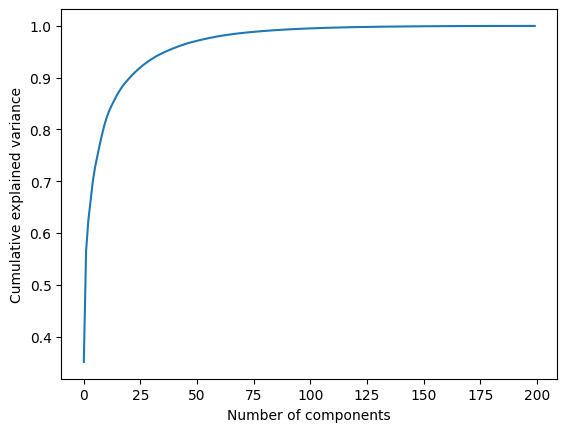

In [167]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=200)
pca.fit(X_train.reshape(X_train.shape[0], -1)) # Fit PCA to the training data

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')

In [244]:
best_params = study.best_params # Get the best hyperparameters
print(f"Best hyperparameters: {best_params}")

Best hyperparameters: {'lstm_units_1': 199, 'lstm_units_2': 65, 'dense_units_1': 22, 'kernel_regularizer_value': 0.0018557259133207917, 'kernel_regularizer_value_2': 0.0001506725837199079, 'kernel_regularizer_value_3': 0.008124399978525354, 'learning_rate': 0.007332934966002386, 'dropout_rate': 0.20245329533525122, 'batch_size': 64}


In [245]:
max_timesteps = X_train.shape[1]
n_features = X_train.shape[2]
final_model = Sequential([
    Input(shape=(max_timesteps, n_features)),
    Masking(mask_value=-1.0),  # Ignore padded zeros
    Bidirectional(LSTM(
        best_params["lstm_units_1"],
        activation="relu",
        dropout=best_params["dropout_rate"],
        recurrent_dropout=best_params["dropout_rate"],
        return_sequences=True,
        kernel_regularizer=l2(best_params["kernel_regularizer_value"])
    )),
    BatchNormalization(),
    Bidirectional(LSTM(
        best_params["lstm_units_2"],
        activation="relu",
        dropout=best_params["dropout_rate"],
        recurrent_dropout=best_params["dropout_rate"],
        kernel_regularizer=l2(best_params["kernel_regularizer_value_2"])
    )),
    BatchNormalization(),
    Dense(
        best_params['dense_units_1'], 
        activation="relu", 
        kernel_regularizer=l2(best_params["kernel_regularizer_value_3"])
        ),
    Dense(1, activation="sigmoid")
])

final_model.compile(
    optimizer=Adam(learning_rate=best_params["learning_rate"]),
    loss="binary_focal_crossentropy",
    metrics=["binary_accuracy"]
)

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


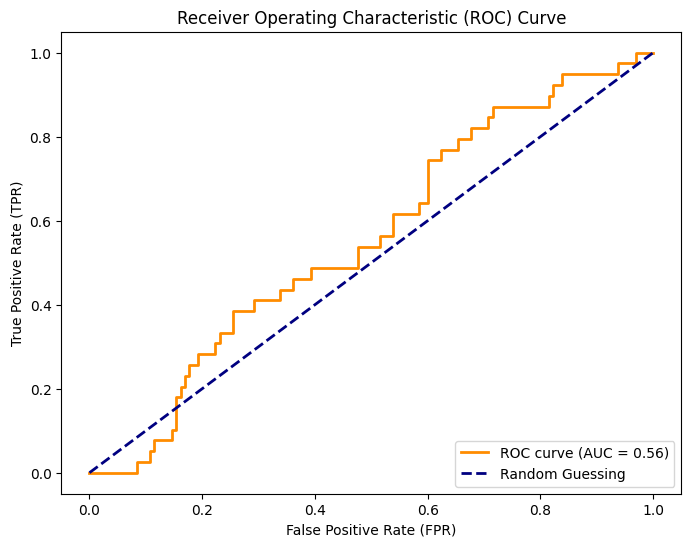

In [246]:
# Predict probabilities for the test set
y_pred_proba = final_model.predict(X_test).ravel()  # Shape: (n_samples,)

# True labels (must be binary: 0 or 1)
y_true = y_test  # Ensure this is a 1D array of 0s and 1s

fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
roc_auc = roc_auc_score(y_true, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guessing')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

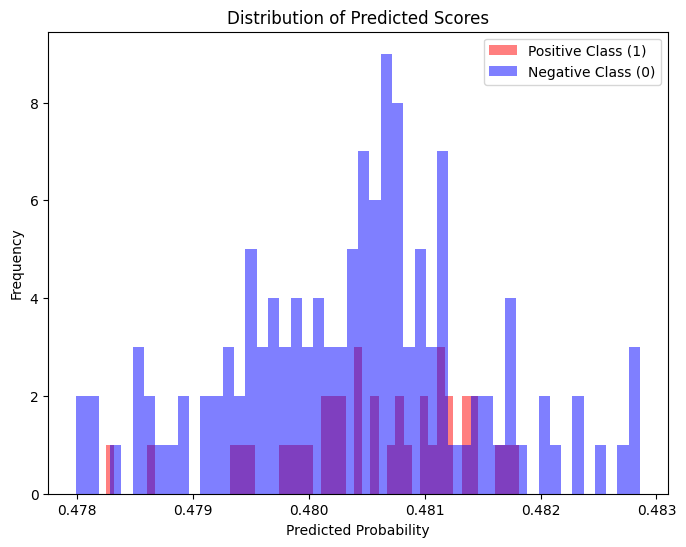

In [247]:
plt.figure(figsize=(8, 6))
plt.hist(y_pred_proba[y_true == 1], bins=50, alpha=0.5, label='Positive Class (1)', color='red')
plt.hist(y_pred_proba[y_true == 0], bins=50, alpha=0.5, label='Negative Class (0)', color='blue')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.title('Distribution of Predicted Scores')
plt.legend()
plt.show()

In [216]:
# Calculate Youden's J statistic
youden_j = tpr - fpr
optimal_idx = np.argmax(youden_j)
optimal_threshold = thresholds[optimal_idx]

print(f"Optimal Threshold: {optimal_threshold:.2f}")

Optimal Threshold: 0.49


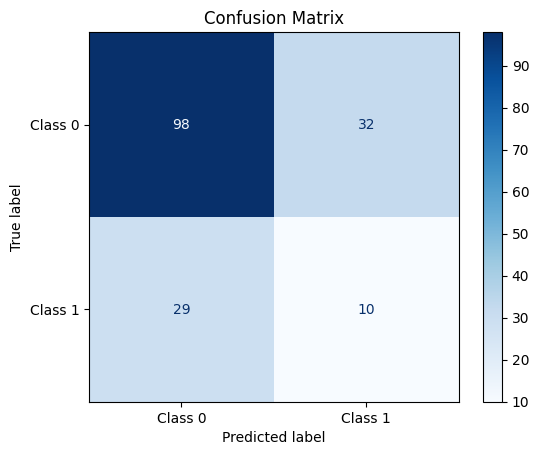

In [217]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Convert probabilities to binary predictions using a threshold (default=0.5)
y_pred = (y_pred_proba >= optimal_threshold).astype(int)

# Plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Class 0', 'Class 1'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

In [365]:
test_loss, test_acc = final_model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_acc}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1369 - loss: nan  
Test Loss: nan, Test Accuracy: 0.16339869797229767


In [230]:
import shap

# INS-W_1

# Testing, ignore this section

In [11]:
TestModel = ModelLSTM() # Create an instance of the ModelLSTM class
rapids_padded = TestModel.create_padded_sequences(rapids_weekly_float)

2025-05-13 15:21:55,015 - INFO - PreprocessorLSTM initialized
2025-05-13 15:21:55,133 - INFO - Created padded sequences with shape: (2360, 819)


In [ ]:
print(np.arange(len(rapids_padded)).shape)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [49]:
x_train, x_test, y_train, y_test = PreprocessorLSTM.split_data(rapids_padded)

2025-05-12 10:47:54,370 - ERROR - Error splitting data: too many indices for array: array is 1-dimensional, but 2 were indexed


In [11]:
rapids_weekly.head(10)

pid,date,dep_weeklysubscale_endterm_merged_false,dep_weeklysubscale_endterm_merged_true,f_slp:fitbit_sleep_summary_rapids_sumdurationafterwakeupmain:14dhist,f_slp:fitbit_sleep_summary_rapids_sumdurationasleepmain:14dhist,f_slp:fitbit_sleep_summary_rapids_sumdurationawakemain:14dhist,f_slp:fitbit_sleep_summary_rapids_sumdurationtofallasleepmain:14dhist,f_slp:fitbit_sleep_summary_rapids_sumdurationinbedmain:14dhist,f_slp:fitbit_sleep_summary_rapids_avgefficiencymain:14dhist,f_slp:fitbit_sleep_summary_rapids_avgdurationafterwakeupmain:14dhist,f_slp:fitbit_sleep_summary_rapids_avgdurationasleepmain:14dhist,f_slp:fitbit_sleep_summary_rapids_avgdurationawakemain:14dhist,f_slp:fitbit_sleep_summary_rapids_avgdurationtofallasleepmain:14dhist,f_slp:fitbit_sleep_summary_rapids_avgdurationinbedmain:14dhist,f_slp:fitbit_sleep_summary_rapids_countepisodemain:14dhist,f_slp:fitbit_sleep_summary_rapids_firstbedtimemain:14dhist,f_slp:fitbit_sleep_summary_rapids_lastbedtimemain:14dhist,f_slp:fitbit_sleep_summary_rapids_firstwaketimemain:14dhist,f_slp:fitbit_sleep_summary_rapids_lastwaketimemain:14dhist,f_slp:fitbit_sleep_intraday_rapids_avgdurationasleepunifiedmain:14dhist,f_slp:fitbit_sleep_intraday_rapids_avgdurationawakeunifiedmain:14dhist,f_slp:fitbit_sleep_intraday_rapids_maxdurationasleepunifiedmain:14dhist,f_slp:fitbit_sleep_intraday_rapids_maxdurationawakeunifiedmain:14dhist,f_slp:fitbit_sleep_intraday_rapids_sumdurationasleepunifiedmain:14dhist,f_slp:fitbit_sleep_intraday_rapids_sumdurationawakeunifiedmain:14dhist,f_slp:fitbit_sleep_intraday_rapids_countepisodeasleepunifiedmain:14dhist,f_slp:fitbit_sleep_intraday_rapids_countepisodeawakeunifiedmain:14dhist,f_slp:fitbit_sleep_intraday_rapids_stddurationasleepunifiedmain:14dhist,f_slp:fitbit_sleep_intraday_rapids_stddurationawakeunifiedmain:14dhist,f_slp:fitbit_sleep_intraday_rapids_mindurationasleepunifiedmain:14dhist,f_slp:fitbit_sleep_intraday_rapids_mindurationawakeunifiedmain:14dhist,f_slp:fitbit_sleep_intraday_rapids_mediandurationasleepunifiedmain:14dhist,f_slp:fitbit_sleep_intraday_rapids_mediandurationawakeunifiedmain:14dhist,f_slp:fitbit_sleep_intraday_rapids_ratiocountasleepunifiedwithinmain:14dhist,f_slp:fitbit_sleep_intraday_rapids_ratiocountawakeunifiedwithinmain:14dhist,f_slp:fitbit_sleep_intraday_rapids_ratiodurationasleepunifiedwithinmain:14dhist,…,f_loc:phone_locations_barnett_probpause_norm:7dhist,f_loc:phone_locations_barnett_rog_norm:7dhist,f_loc:phone_locations_barnett_siglocentropy_norm:7dhist,f_loc:phone_locations_barnett_siglocsvisited_norm:7dhist,f_loc:phone_locations_barnett_stdflightdur_norm:7dhist,f_loc:phone_locations_barnett_stdflightlen_norm:7dhist,f_loc:phone_locations_barnett_wkenddayrtn_norm:7dhist,f_loc:phone_locations_doryab_avglengthstayatclusters_norm:7dhist,f_loc:phone_locations_doryab_avgspeed_norm:7dhist,f_loc:phone_locations_doryab_homelabel_norm:7dhist,f_loc:phone_locations_doryab_locationentropy_norm:7dhist,f_loc:phone_locations_doryab_locationvariance_norm:7dhist,f_loc:phone_locations_doryab_loglocationvariance_norm:7dhist,f_loc:phone_locations_doryab_maxlengthstayatclusters_norm:7dhist,f_loc:phone_locations_doryab_minlengthstayatclusters_norm:7dhist,f_loc:phone_locations_doryab_movingtostaticratio_norm:7dhist,f_loc:phone_locations_doryab_normalizedlocationentropy_norm:7dhist,f_loc:phone_locations_doryab_numberlocationtransitions_norm:7dhist,f_loc:phone_locations_doryab_numberofsignificantplaces_norm:7dhist,f_loc:phone_locations_doryab_outlierstimepercent_norm:7dhist,f_loc:phone_locations_doryab_radiusgyration_norm:7dhist,f_loc:phone_locations_doryab_stdlengthstayatclusters_norm:7dhist,f_loc:phone_locations_doryab_timeathome_norm:7dhist,f_loc:phone_locations_doryab_timeattop1location_norm:7dhist,f_loc:phone_locations_doryab_timeattop2location_norm:7dhist,f_loc:phone_locations_doryab_timeattop3location_norm:7dhist,f_loc:phone_locations_doryab_totaldistance_norm:7dhist,f_loc:phone_locations_doryab_varspeed_norm:7dhist,f_loc:phone_locations_locma

In [13]:
target = rapids_weekly.select("dep_weeklysubscale_endterm_merged_true").to_numpy().tolist()
features = rapids_weekly.to_numpy().tolist()

In [ ]:
sleep_1 = preprocessor_INS_W1.import_csv_feature_data("sleep")
wifi_1 = preprocessor_INS_W1.import_csv_feature_data("wifi")
bluetooth_1 = preprocessor_INS_W1.import_csv_feature_data("bluetooth")
call_1 = preprocessor_INS_W1.import_csv_feature_data("call")
location_1 = preprocessor_INS_W1.import_csv_feature_data("location")
screen_1 = preprocessor_INS_W1.import_csv_feature_data("screen")
steps_1 = preprocessor_INS_W1.import_csv_feature_data("steps")

In [120]:
sleep_wifi_temp_1 = preprocessor_INS_W1.merge_survey_to_feature(sleep_1, wifi_1, join_type="inner")
bluetooth_call_temp_1 = preprocessor_INS_W1.merge_survey_to_feature(bluetooth_1, call_1, join_type="inner")
location_screen_temp_1 = preprocessor_INS_W1.merge_survey_to_feature(location_1, screen_1, join_type="inner")

sleep_wifi_steps_1 = preprocessor_INS_W1.merge_survey_to_feature(sleep_wifi_temp_1, steps_1, join_type="inner")
bluetooth_call_location_screen = preprocessor_INS_W1.merge_survey_to_feature(bluetooth_call_temp_1, location_screen_temp_1, join_type="inner")
merged_all_temp = preprocessor_INS_W1.merge_survey_to_feature(sleep_wifi_steps_1, bluetooth_call_location_screen, join_type="inner")